# Global data handling

In this notebook, we import all the different dataset useful for our analysis, we merge them together and we format the data.

We work with 2 different datasets, from BeerAdvocate and from RateBeer. We must therefore achieve a normalisation of values to make them compatible. We must also keep only once the users and breweries that exist in the 2 datasets.

But the first step is to import the ratings of the 2 datasets. These data are stored in txt files of several GB. One have to be careful to optimize the data types and to select only the useful data to reduce the volume of data to be handled afterwards.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
from sys import getsizeof
import pickle

### Define some useful function

In [2]:
########################################################
# This function format and print the time taken by a proccess to execute
#   Input : start, end = time in seconds
#   Output : end = the time when the process finish (useful to store it in a startProcess variable)
########################################################
def printTime(start, end):
    dt = end - start
    m = dt//60
    s = dt-m*60
    print("   Time elapsed : {} min {:.3f} sec\n".format(m,s))
    return end

########################################################
# This function compute and return the total size in byte of a dictionnary
#   Input : dico = dictionnary variable
#   Output : size = size in byte of dico
########################################################
def getSize(dico):
    size = 0
    for k in dico.keys():
        size += getsizeof(dico[k])
    return size

########################################################
# This function print some statistic about a DataFrame : Memory usage, index values, columns name,type and size
#   Input : df = DataFrame
########################################################
def showMemoryUsage(df):
    print("Dataframe contain {} rows. [{} to {}]".format(df.shape[0], np.min(df.index), np.max(df.index)))
    mem = df.memory_usage(deep=True)
    print("Total memory usage : {:.3f}GB".format(np.sum(mem)/(2**30)))
    print("   #   Name              Type             Size          # of Na values")
    print("  ---  ---------------   --------------   -----------   --------------")
    typ = df.dtypes
    na = df.isna().sum()
    i = 0
    for k, v in mem.items():
        if k=='Index': # Skip Index because it is not return by dtypes
            continue
        print("   {:<2}  {:<16}  {:<14}   {:>8.1f}MB    {:>10}".format(i,k,str(typ[k]),v/(2**20), na[k]))
        i+=1

## 1. Import data from ratings.txt

In this first part, we load the files ´ratings.txt´ from BeerAdvocate and RateBeer. These files contain values from 16 to 17 columns. Each line of the file contain one column name and one value. A row is obtained after reading around 17 lines.

Here, we define where the file are and we show an overview of the begining of the file :

In [3]:
folderRB = '../data/RateBeer/'
folderBA = 'Beer/BeerAdvocate/'
folderM =  'Beer/matched_beer_data/'
fileBrew = 'breweries.csv'
fileRating = 'ratings.txt'
fileUser = 'users.csv'

f = open(folderRB + fileRating, 'r', encoding='utf-8')

headers = np.array([])
i=0
for line in f:
    print(line)
    title = line.replace('\n','').split(': ')[0]
    if len(title)>2:
        if title!='text':
            headers = np.append(headers, title)
            
    #We have see all col name in less than 30 line
    i+=1
    if i>25:
        break
        
f.close()

print("===============================================================================")
print("List of columns name : ")
np.unique(headers)

beer_name: 33 Export (Gabon)

beer_id: 410549

brewery_name: Sobraga

brewery_id: 3198

style: Pale Lager

abv: 5.0

date: 1461664800

user_name: Manslow

user_id: 175852

appearance: 2

aroma: 4

palate: 2

taste: 4

overall: 8

rating: 2.00

text: Puszka 0,33l dzięki Christoph . Kolor jasnozłoty, piana biała drobnoziarnista szybko opada. Aromat słodowy, lekko słodkie.Dość dobre. 



beer_name: Castel Beer (Gabon)

beer_id: 105273

brewery_name: Sobraga

brewery_id: 3198

style: Pale Lager

abv: 5.2

date: 1487329200

user_name: MAGICuenca91

user_id: 442761

List of columns name : 


array(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style',
       'taste', 'user_id', 'user_name'], dtype='<U32')

With this overview, we can see which lines are intersting for us and if the data are a number or a string. To reduce the size of the imported data, we will not get the `text` because we do not need it for our analyses and `brewery_name` and `beer_name` because these data are already in the brewery.csv, respectively beer.csv file, we just need the id to match them togeter. 

For the numerical data, we directly convert them to the appropriate data type. Note : by befault, python use 64 bits numerical data type. This is unecessary for us because we don't have integer above 20 million, negative number and our floating number don't need a large precision. Therfore we force python to use data type over 32 bits to reduce by a factor 2 the memory involved.

Also we discover that native python data type and operation over them are way faster than using directly Numpy or Pandas. So the data are imported in a simple dictionnary of list. For the process, we need to add new data at the end of the list. We should normaly avoid to proced like that and direcly allocate enough memory space to store the entire dataset. This avoids having to allocate a new, larger memory space to copy the whole list into it when we want to add an item, because that takes time. But we cannot do that because we don't know in advance how many data we have. 
Interetingly, with the output of the next cell, we can see how Python process when we add item to a list. You can see that the memory used grows with each print at the begining, and then stay constant for more and more prints although the same number of elements are added between each print. This is because when the memory space is fully used by the list and an new item is added, Python allocates a new memory space 1.2 times larger to copy the list into. For subsequent additions, there is no need to reserve a new memory space because there is still space in the current one. as each element is the same size, we can store more elements when we add 20% of memory in an already long list.

In [4]:
start = time.time()
print("Step 1 : initialisation")

BEER_ADVOCATE = False

headers = np.array(['beer_id', 'brewery_id', 'date', 'abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'style', 'taste', 'user_id', 'user_name'])
headers_float = set(['abv','appearance','aroma','palate','taste','overall','rating'])
headers_int = set(['user_id','beer_id','brewery_id','date'])  
headers_skip = set(['text','brewery_name', 'beer_name'])

if BEER_ADVOCATE:
    headers = np.append(headers, 'review')
    headers_int -= {'user_id'}

# Initialisation of the data container
data = {}
for k in headers:
    data[k] = list()

start = printTime(start, time.time())
# Read all the file
print("Step 2 : Read the file")
i = 0
threshold = 5000000

f = open(folderRB + fileRating, 'r', encoding='utf-8')

for line in f:
    # Separe header of its value
    val = line.replace('\n','').split(': ',1)
    if len(val)>1: # skip empty line
        
        # Comparation between set is much faster than between list
        header = set([val[0]])
        if not not headers_float & header:
            # if the column contain float number, add the value as float
            data[val[0]].append(np.float32(val[1]))
        elif not not headers_int & header:
            # if the column contain float number, add the value as interger
            data[val[0]].append(np.uint32(val[1]))
        elif not headers_skip & header:
            # if the column is not skipped, add the value as string
            data[val[0]].append(val[1])
    i+=1
    # Show the progression each million lines
    if i==threshold:
        threshold += 5000000
        s = getSize(data)
        print("   Data size : {:.2f}MB".format(s/(2**20)))
        if s/(2**30) > 6: #interrupt when 6 GB of data are take
            break
            
    # For develloppement, limit the reading of the file to 5'000'000 of line
    #if i>5000000:
    #    break
        
f.close()
# flush memory
gc.collect()

start = printTime(start, time.time())
print("Step 3 : Uniformize length")
# uniformize length : some columns have one item less because when the data were collected on the internet, 
# the end of the file was truncated
length = 1e12
for k in headers:
    if length > len(data[k]):
        length = len(data[k])
print("   common length : " + str(length))

for k in headers:
    data[k] = data[k][:length]
    
start = printTime(start, time.time())

# Saving the data to pickle here allow to reduce the amount of memory used but increase the computation time because
# the standard pickle library is not optimized for large data
print("Step 4 : Save to pickle")
print("   This step is skipped !")
REDUCE_MEMORY = False
#for k in headers:
#    file = open(f'../data/tmp/data_{k}.pkl', 'wb')
#    pickle.dump(data[k], file)
#    file.close()
#    del data[k]
#    gc.collect()

start = printTime(start, time.time())

Step 1 : initialisation
   Time elapsed : 0.0 min 0.001 sec

Step 2 : Read the file
   Data size : 32.25MB
   Data size : 65.39MB
   Data size : 93.11MB
   Data size : 117.84MB
   Data size : 149.14MB
   Data size : 188.76MB
   Data size : 212.35MB
   Data size : 238.90MB
   Data size : 268.76MB
   Data size : 302.35MB
   Data size : 340.15MB
   Data size : 382.67MB
   Data size : 382.67MB
   Data size : 430.50MB
   Data size : 484.32MB
   Data size : 484.32MB
   Data size : 544.86MB
   Data size : 544.86MB
   Data size : 612.96MB
   Data size : 612.96MB
   Data size : 612.96MB
   Data size : 689.58MB
   Data size : 689.58MB
   Data size : 775.78MB
   Time elapsed : 5.0 min 5.192 sec

Step 3 : Uniformize length
   common length : 7122074
   Time elapsed : 0.0 min 4.693 sec

Step 4 : Save to pickle
   This step is skipped !
   Time elapsed : 0.0 min 0.000 sec



The fastest way to convert a diconnary to a DataFrame is to 
1. convert each columns to a numpy array (the data are copied a second time in the memory)
2. convert the array to a Series (allow in situ conversion, no copy are made)
3. concatenate the Series together

We have tested to create directly a DataFrame but this operation is a lot slower.
When converting a column, we take advantage of changing the data type to optimise the space used in the memory. We have 3 ways to reduce the memory used:
- convert string to boolean
- use categories when strings appear several times. Each string is then stored only once and is replaced by an id in the data
- Use the string data format of pyarrow. This reduces the number of bits used to encapsulate strings

We also clean the user name from wrong value here to reduce the amount of memory used (the conversion take a lot of memory if the string are large, which is the case only for wrong value).

As soon as we can, we delete the used data and force the memory to free the empty space with `gc.collect()`

In [5]:
start = time.time()

if REDUCE_MEMORY:
    #headers = np.array(['user_id', 'user_name', 'beer_id', 'brewery_id', 'date', 'abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'style', 'taste', 'review'])
    data = {}

# Convert to a dataframe
print("Step 5 : Convert to a dataframe")

serieList = np.empty(len(headers), pd.Series)
for i, k in enumerate(headers):
    
    if REDUCE_MEMORY:
        file = open(f'../data/tmp/data_{k}.pkl', 'wb')
        data[k] = pickle.load(file)
        file.close()
    
    # Convert columns imported as string to true type to reduce memory
    if k=='style':
        # convert style to categorical data to reduce the memory used
        serieList[i] = pd.Series(np.array(data[k]), copy = False, dtype="category")
    elif k=='review':
        # convert review to boolean (reduce the memory used as well)
        serieList[i] = pd.Series(np.array(data[k]), copy = False).replace({'True':True, 'False':False})
    elif k=='user_name':
        # Some user_name contain wrong data. Their length is thus increased. 
        # We detect too long user_name to remove a wrong data collaspsed
        for j, t in enumerate(data[k]):
            if len(t) > 250:
                # The user_name is located after the last XML tag
                name = t.split('>')[-1]
                # Some user try to inject code in the user name field. The string doesn't contain any user_name
                data[k][j] = name if name!='' else "Malicious user"
        serieList[i] = pd.Series(np.array(data[k]), copy = False, dtype="string[pyarrow]")
    elif k=='user_id' and BEER_ADVOCATE:  # don't apply for RateBeer
        # in BA, the user_id contain the user_name lowered follow by a dot and a unique key. Here we remove 
        # the first part as we already save it in user_name and because number take less space in the memory
        serieList[i] = pd.Series(np.array([t.split('.',1)[1] for t in data[k]], dtype=np.uint32), copy = False)
    else:
        # For numeric column, the conversion is already done
        serieList[i] = pd.Series(np.array(data[k]), copy = False)
    
    # erase no longer useful data
    del data[k]
    gc.collect()
    print("   Successfully convert {}".format(k))

# Concatenate the Series to one DataFrame
df = pd.concat(serieList, axis=1, copy=False)
# set the columns name because the Series doesn't containt a column name
df.columns = headers

# convert the date
df.date = pd.to_datetime(df.date, unit='s')

if not BEER_ADVOCATE:
    # Add a missing column in RateBeer
    df['review'] = False

# flush the memory
del data
gc.collect()

start = printTime(start, time.time())
# Show the result of the conversion
df.sample(8)

Step 5 : Convert to a dataframe
   Successfully convert beer_id
   Successfully convert brewery_id
   Successfully convert date
   Successfully convert abv
   Successfully convert appearance
   Successfully convert aroma
   Successfully convert overall
   Successfully convert palate
   Successfully convert rating
   Successfully convert style
   Successfully convert taste
   Successfully convert user_id
   Successfully convert user_name
   Time elapsed : 0.0 min 50.036 sec



,beer_id,brewery_id,date,abv,appearance,aroma,overall,palate,rating,style,taste,user_id,user_name,review
2114587,360807,21301,2016-02-28 11:00:00,5.0,3.0,7.0,15.0,3.0,3.5,American Pale Ale,7.0,38926,fonefan,False
4638813,207828,10567,2015-01-18 11:00:00,8.3,4.0,6.0,12.0,3.0,3.0,American Strong Ale,5.0,954,joet,False
1985207,42497,10271,2007-06-28 10:00:00,7.5,2.0,6.0,13.0,4.0,3.2,Abbey Dubbel,7.0,5328,Ungstrup,False
5583151,123704,639,2014-09-09 10:00:00,11.1,4.0,7.0,14.0,4.0,3.7,Barley Wine,8.0,138596,keanex,False
5039367,441769,13210,2016-09-06 10:00:00,5.5,3.0,6.0,14.0,3.0,3.3,Fruit Beer,7.0,163121,BrownALEx,False
6632914,136669,167,2012-06-03 10:00:00,8.0,3.0,5.0,14.0,3.0,3.0,Fruit Beer,5.0,152428,Hogfather,False
6606967,6170,1718,2005-03-05 11:00:00,11.0,4.0,5.0,16.0,4.0,3.6,Abt/Quadrupel,7.0,18320,Psylocke,False
5389595,486276,24175,2017-04-28 10:00:00,12.0,4.0,7.0,16.0,4.0,3.9,Imperial Stout,8.0,96358,dfinney23,False


We have now a DataFrame containing all useful data from rating.txt. As you can see, even if the code is optimised to run fast, it takes a few minutes to get this DataFrame. We now need to save it to avoid to run this code again each time. Let's do it and show how many memory is used and with witch type :

In [6]:
showMemoryUsage(df)

Dataframe contain 7122074 rows. [0 to 7122073]
Total memory usage : 0.413GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   beer_id           uint32               27.2MB             0
   1   brewery_id        uint32               27.2MB             0
   2   date              datetime64[ns]       54.3MB             0
   3   abv               float32              27.2MB        174984
   4   appearance        float32              27.2MB             0
   5   aroma             float32              27.2MB             0
   6   overall           float32              27.2MB             0
   7   palate            float32              27.2MB             0
   8   rating            float32              27.2MB             0
   9   style             category              6.8MB             0
   10  taste             float32              27.2MB             0
   11  user_id           uint32              

In [7]:
start = time.time()
print("Saving to pickle...")
df.to_pickle(folderRB + 'ratings.pkl')
start = printTime(start, time.time())
print("Saving to csv...")
df.to_csv(folderRB + 'ratings.csv')
start = printTime(start, time.time())

Saving to pickle...
   Time elapsed : 0.0 min 0.650 sec

Saving to csv...
   Time elapsed : 1.0 min 8.187 sec



The above code has to be run two times to get the data of the two dataset, BeerAdvocate and RateBeer.

## 2. Merge the two dataset together

For the second part, we import the users dataset and brewery dataset for both BeerAdvocate and RateBeer and we merge them together. We have to remove redundant row which are in both dataset. We also replace nan value to avoid error later and we check if there are no wrong data.

## 2.1 Merge the users

In [8]:
#Define the data type for the importation
colType = {'nbr_ratings': np.int32, 'user_id': np.int32, 'user_name' : 'string[pyarrow]', 'joined': np.float32, 'location': 'category'}

dfRB = pd.read_csv(folderRB+fileUser, encoding='utf-8', dtype=colType)
colType['nbr_reviews'] = np.uint32
del colType['user_id']
dfBA = pd.read_csv(folderBA+fileUser, encoding='utf-8', dtype=colType)
dfM = pd.read_csv(folderM +fileUser, header=1, usecols=[4,5,10,11], encoding='utf-8') 

# Add the missing column nbr_reviews to RB
dfRB['nbr_reviews'] = np.uint32(0)

# Create a correspondance table user_id form BA to user_id compatible with RB
user_id_ba2rb = {} 
for i, v in dfM[['user_id','user_id.1']].iterrows():
    user_id_ba2rb[v[0]] = v[1]
    
idMin = dfRB.user_id.max()+1
for i, v in dfBA[['user_id']].iterrows():
    user_id_ba2rb[v[0]] = idMin + i


# For user that are both in BA and RB, keep only the one from RB
df4 = dfBA.set_index('user_id').drop(dfM['user_id'])

# replace user_id of BA with shifted values (new_id = max_id_RB + old_id)
df4.index = np.arange(idMin, idMin+df4.user_name.size)

# Merge the two dataframe togeter
users = pd.concat([dfRB.set_index('user_id'), df4])

# format the date
users.joined = pd.to_datetime(users.joined, unit='s')

# Clean the memory
del dfRB, dfBA, dfM, df4
gc.collect()

users.sample(5)

,nbr_ratings,user_name,joined,location,nbr_reviews
383341,7,joergen_wulff,2015-09-03 09:59:28,Denmark,0
47953,2,BeerItinMind,2007-01-11 10:59:12,Mexico,0
560916,14,jaquirk,2011-01-09 10:59:12,"United States, North Carolina",0
518312,66,rbail012,2014-07-25 09:59:28,NaN,0
52531,7,deliroare,2007-04-06 09:59:28,Northern Ireland,0


We have verify that the users Dataframe contain no wrong data. The location are fine but some user_name contain xml balise. Therefore we add a filter to correct these user_name. If the user_name is at the end of the balise, we can extract it. If there is only xml code, it is probably a tentative of hacking and not an error.

For nbr_ratings and nbr_reviews, the values follow a geometric distribution with a few outliers. We chose to identify them by replace the user_name by 'outlier' for user which have more than 20'000 ratings or 4000 reviews.

Also, we replace all missing value in string field by a text 'NA' to avoid error after.

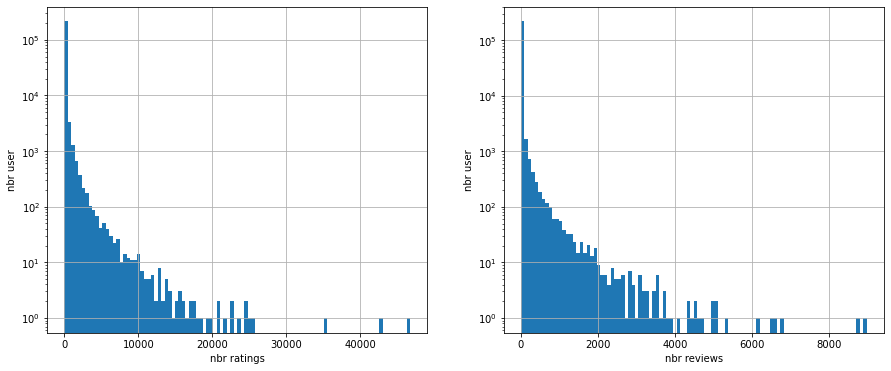

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
users.nbr_ratings.hist(bins=100, log=True, ax=axes[0])
users.nbr_reviews.hist(bins=100, log=True, ax=axes[1])
axes[0].set_xlabel("nbr ratings"); axes[0].set_ylabel("nbr user")
axes[1].set_xlabel("nbr reviews"); axes[1].set_ylabel("nbr user")
plt.show()

In [10]:
users.nbr_ratings.fillna(0, inplace=True)
users.nbr_reviews.fillna(0, inplace=True)

users.location.fillna('NA', inplace=True)
users.location = users.location.astype('category')

users.user_name.fillna('NA', inplace=True)
for j, t in enumerate(users.user_name):
    if len(t) > 50:
        u = t.split('>')[-1]
        users.user_name.iloc[j] = u if u!='' else "Malicious user"
        
users.user_name.loc[users.nbr_ratings > 20000] = 'outlier'
users.user_name.loc[users.nbr_reviews > 4000]  = 'outlier'

In [11]:
# Print some information about the type and the memory usage
showMemoryUsage(users)

Dataframe contain 220858 rows. [2 to 640598]
Total memory usage : 0.008GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   nbr_ratings       int32                 0.8MB             0
   1   user_name         string                2.8MB             0
   2   joined            datetime64[ns]        1.7MB          2682
   3   location          category              0.4MB             0
   4   nbr_reviews       uint32                0.8MB             0


## 2.2 Merge breweries

In [12]:
# Define the data type for the importation
colType = {'nbr_beers': np.int32, 'id': np.int32, 'name' : 'string[pyarrow]', 'location': 'string[pyarrow]'}

# Import brewery dataset
dfRB = pd.read_csv(folderRB+fileBrew, encoding='utf-8', dtype=colType)
dfBA = pd.read_csv(folderBA+fileBrew, encoding='utf-8', dtype=colType)
dfM = pd.read_csv(folderM+fileBrew, header=1, encoding='utf-8')

# For breweries that are both in BA and RB, keep only the one from RB
breweries = dfBA.set_index('id').drop(dfM['id'])
brew_shift = dfRB.id.max()
breweries.index += brew_shift
breweries = pd.concat([dfRB.set_index('id'), breweries])

# Clean the memory
del dfRB, dfBA, dfM
gc.collect()

breweries.sample(5)

,location,name,nbr_beers
id,,,
9249,South Africa,Roca Micro Brewery,3
6342,"United States, North Carolina",Heinzelmannchen Brewery,18
74634,"United States, Colorado",Rock Cut Brewing Company,15
13343,England,Suma,1
31296,"United States, Colorado",Lady Justice Brewing,5


Now, we check if there are wrong data. We have found that there are no wrong breweries name. But some location contain a xml link inside. So we remove the link to keep only the location. We also make some small adjustments to match the users' locations.

In [13]:
for j, v in breweries.location.items():
    if v[:3] == 'Can':
        breweries['location'][j] = 'Canada'
    elif v[:8] == 'United K':
        breweries['location'][j] = 'United Kingdom'
    elif v[:7] == 'UNKNOWN':
        breweries['location'][j] = 'NA'
    if len(v) > 40:
        t = v.split('<', 1)[0]
        if t!='United States':
            t = 'United States, ' + t
        breweries['location'][j] = t
        
breweries.location.loc[breweries.location == 'United States, United States'] = 'United States, Washington DC'
breweries.location.loc[breweries.location == 'United States'] = 'United States, Washington DC'
        
breweries.location = breweries.location.astype('category')

In [14]:
# Print some information about the type and the memory usage
showMemoryUsage(users)

Dataframe contain 220858 rows. [2 to 640598]
Total memory usage : 0.008GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   nbr_ratings       int32                 0.8MB             0
   1   user_name         string                2.8MB             0
   2   joined            datetime64[ns]        1.7MB          2682
   3   location          category              0.4MB             0
   4   nbr_reviews       uint32                0.8MB             0


With the code below, we can note that there are country with a breweries or more but where nobody have write a rating. The breweries are known because their beers are sold abroad but there are no users of BeerAdvocate or RateBeer in these countries. Here we can see the limit of our dataset. It is not representative of the situation all over the world but only in countries that have easy access to the internet and where there are people who speak English.

In [15]:
a = set(breweries.location.cat.categories)
b = set(users.location.cat.categories)
print(f"There is {len(a-b)} country without breweries")
print(f"There is {len(b-a)} country with breweries but without beer ratings")

There is 46 country without breweries
There is 28 country with breweries but without beer ratings


## 2.3 Merge ratings

Here we import the data extracted in the section 1. We make some scaling down on the evalution of aroma, taste and overall to have the same range of evaluation for the two datasets. All evaluation values are now comprised between 0 and 5. The other rows are well formated and have no wrong values.

In [16]:
ratings_RB = pd.read_pickle(folderRB + "rb_rating.pkl")

# Scale down these field to have all evaluation on the same range
ratings_RB.aroma /= 2
ratings_RB.taste /= 2
ratings_RB.overall /= 4
ratings_RB.sample(8)

,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,style,taste,user_id,user_name,review
1165269,7.2,3.0,3.0,11967,1839,2011-03-22 11:00:00,3.50,3.0,3.3,Doppelbock,3.5,22228,BelgiskOlklub,False
3097250,9.0,5.0,4.0,202932,11963,2013-12-23 11:00:00,3.75,4.0,3.9,Imperial IPA,3.5,234971,Tongan77,False
6032051,3.6,4.0,3.0,107508,2443,2013-12-17 11:00:00,3.25,4.0,3.3,Bitter,3.0,208877,Theydon_Bois,False
601037,8.5,3.0,4.5,101685,10032,2013-06-27 10:00:00,4.00,4.0,4.0,Black IPA,4.0,79927,joeneugs,False
3315903,5.7,3.0,3.5,253699,13912,2016-07-03 10:00:00,3.50,3.0,3.4,Saison,3.5,126758,tom10101,False
6438825,5.9,3.0,2.5,38306,862,2014-06-18 10:00:00,2.75,3.0,2.8,Belgian Ale,3.0,123903,AndySnow,False
6218998,4.9,3.0,3.0,85937,9078,2009-07-27 10:00:00,3.25,3.0,3.2,Premium Bitter/ESB,3.5,29087,DJMonarch,False
5809135,5.0,3.0,3.0,383374,2521,2011-01-21 11:00:00,3.75,3.0,3.3,Premium Bitter/ESB,3.0,74136,Leighton,False


In [17]:
showMemoryUsage(ratings_RB)

Dataframe contain 7122074 rows. [0 to 7122073]
Total memory usage : 0.413GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   abv               float32              27.2MB        174984
   1   appearance        float32              27.2MB             0
   2   aroma             float32              27.2MB             0
   3   beer_id           uint32               27.2MB             0
   4   brewery_id        uint32               27.2MB             0
   5   date              datetime64[ns]       54.3MB             0
   6   overall           float32              27.2MB             0
   7   palate            float32              27.2MB             0
   8   rating            float32              27.2MB             0
   9   style             category              6.8MB             0
   10  taste             float32              27.2MB             0
   11  user_id           uint32              

For BeerAdvocate data, we have to tranform the brewery and user id to match with the users DataFrame and the breweries DataFrame. This is done to avoid duplicated id between RateBeer and BeerAdvocate. Otherwise, all evaluation values are comprised between 0 and 5. The other rows are well formated and have no wrong values.

We can note that ther are always the same number of nan values for appearance, aroma, palate, taste and overall. This is probably due to the absence of these fields in the database during the first years of the site's existence, or because the data has been lost. In any case, it is not random loss or corruption of data.

In [18]:
ratings_BA = pd.read_pickle(folderBA + "ba_ratings.pkl")
# Transformation of the id columns to avoid conflict with RB
ratings_BA.brewery_id += brew_shift
ratings_BA.user_id = ratings_BA.user_id.apply(lambda x : user_id_ba2rb[x]).astype(np.uint32)
ratings_BA.sample(8)

,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,review,style,taste,user_id,user_name
6510273,7.0,NaN,NaN,2511,32533,2014-12-03 11:00:00,NaN,NaN,3.25,False,American Stout,NaN,491648,ejmw
8355520,NaN,NaN,NaN,116934,51762,2014-03-30 10:00:00,NaN,NaN,3.00,False,Scottish Ale,NaN,496883,trytoketchup
1802385,10.2,4.00,4.00,86149,32386,2013-01-07 11:00:00,4.50,4.5,3.95,True,Russian Imperial Stout,3.50,491845,charlzm
8051408,7.0,NaN,NaN,74778,32462,2013-11-16 11:00:00,NaN,NaN,4.75,False,Flanders Red Ale,NaN,501626,random846
8007029,6.0,3.75,3.50,90903,33071,2016-01-21 11:00:00,3.25,3.5,3.37,False,Saison / Farmhouse Ale,3.25,501661,TheFightfan1
5095264,5.0,3.50,3.25,82803,60116,2017-01-29 11:00:00,3.50,3.5,3.44,False,American Pale Wheat Ale,3.50,532982,dms1767
60250,4.0,3.00,3.00,73985,35611,2011-10-10 10:00:00,3.50,3.5,3.15,True,English Pale Ale,3.00,490274,stcules
2626831,10.0,2.50,4.00,44932,49112,2015-09-28 10:00:00,3.50,3.5,3.76,True,Fruit / Vegetable Beer,4.00,498586,Briken


In [19]:
showMemoryUsage(ratings_BA)

Dataframe contain 8393032 rows. [0 to 8393031]
Total memory usage : 0.493GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   abv               float32              32.0MB        171305
   1   appearance        float32              32.0MB       3623357
   2   aroma             float32              32.0MB       3623357
   3   beer_id           uint32               32.0MB             0
   4   brewery_id        uint32               32.0MB             0
   5   date              datetime64[ns]       64.0MB             0
   6   overall           float32              32.0MB       3623357
   7   palate            float32              32.0MB       3623357
   8   rating            float32              32.0MB             0
   9   review            bool                  8.0MB             0
   10  style             category              8.0MB             0
   11  taste             float32             

In [20]:
# Merge the two DataFrame
ratings = pd.concat([ratings_RB,ratings_BA], copy = False)
ratings.reset_index(inplace=True)
ratings.drop(columns='index', inplace=True)
#ratings['style'] = ratings['style'].astype('category')
showMemoryUsage(ratings)

Dataframe contain 15515106 rows. [0 to 15515105]
Total memory usage : 1.961GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   abv               float32              59.2MB        346289
   1   appearance        float32              59.2MB       3623357
   2   aroma             float32              59.2MB       3623357
   3   beer_id           uint32               59.2MB             0
   4   brewery_id        uint32               59.2MB             0
   5   date              datetime64[ns]      118.4MB             0
   6   overall           float32              59.2MB       3623357
   7   palate            float32              59.2MB       3623357
   8   rating            float32              59.2MB             0
   9   style             object             1094.9MB             0
   10  taste             float32              59.2MB       3623357
   11  user_id           uint32            

## 2.4 Simply the styles

For our analysis, we don't need so much detail on the beer styles. We want to reduce the number of categories to a few main styles. We have therefore classified the styles in a table which is displayed below. We then use this dictionary to simplify the styles in the ratings.

In [21]:
type_2_beer = {
    
    'Bock':             ['Heller Bock','Dunkler Bock','Doppelbock','Bock','Eisbock','Maibock','Weizenbock','Maibock / Helles Bock'],
    
    'Porter':           ['Baltic Porter','Imperial Porter','Porter','American Porter','English Porter',
                         'Robust Porter','Smoked Porter'],
    
    'Specialty Beer':   ['Specialty Grain','Smoked','Fruit Beer','Low Alcohol','Low Alcohol Beer','Sahti/Gotlandsdricke/Koduõlu',
                         'Traditional Ale','Chile Beer','Fruit and Field Beer','Gruit','Ancient Herbed Ale','Scottish Gruit / Ancient Herbed Ale',
                         'Happoshu','Herb and Spice Beer','Kvass','Low-Alcohol Beer','Pumpkin Beer','Pumpkin Ale','Rye Beer',
                         'Sahti','Smoked Beer','Bière de Champagne / Bière Brut','Bière de Champagne','Bière Brut','Braggot','Steam Beer',
                        'Black & Tan','California Common / Steam Beer','Fruit / Vegetable Beer','Herbed / Spiced Beer'],
    
    'Stout':            ['Dry Stout','American Double / Imperial Stout','Foreign Stout','Imperial Stout','Stout','Sweet Stout',
                         'Milk / Sweet Stout','American Imperial Stout','American Stout','English Stout','Foreign','Export Stout',
                         'Irish Dry Stout','Oatmeal Stout','Russian Imperial Stout','Sweet / Milk Stout','Foreign / Export Stout'],
    
    'Sour':             ['Sour Red/Brown','Sour/Wild Ale','Berliner Weisse','Grodziskie/Gose/Lichtenhainer',
                         'Lambic Style - Faro','Lambic Style - Fruit','Lambic - Fruit','Lambic Style - Gueuze',
                         'Lambic Style - Unblended','Lambic - Unblended','Fruit Lambic','Fruited Kettle Sour','Faro','Gose','Gueuze'
                        ,'Lambic','Wild Ale','Flanders Oud Bruin','Flanders Red Ale','Brett Beer','American Wild Ale'],
    
    'Wheat Beer':       ['Dunkelweizen','German Hefeweizen','German Kristallweizen','Weizen Bock','Wheat Ale',
                         'Witbier','American Dark Wheat Beer','American Pale Wheat Beer','Grodziskie',
                         'Hefeweizen','Kristallweizen','American Dark Wheat Ale','American Pale Wheat Ale','Berliner Weissbier',
                        'Kristalweizen'],
    
    'Saké':             ['Saké - Daiginjo','Saké - Futsu-shu','Saké - Genshu','Saké - Ginjo','Saké - Honjozo',
                        'Saké - Infused','Saké - Junmai','Saké - Koshu','Saké - Namasaké','Saké - Nigori',
                        'Saké - Taru','Saké - Tokubetsu','Japanese Rice Lager'],
    
    'Belgian Ale':      ['Abbey Dubbel','Abbey Tripel','Abt/Quadrupel','Belgian Ale','Belgian Strong Ale',
                         'Bière de Garde','Saison','Belgian IPA','Belgian Blonde Ale','Belgian Pale Ale','Belgian Strong Pale Ale',
                        'Saison / Farmhouse Ale'],
    
    'IPA':              ['Black IPA','American IPA','Brut IPA','English IPA',
                         'Milkshake IPA','New England IPA','English India Pale Ale (IPA)','India Pale Ale (IPA)'],
    
    'IIPA':             ['American Double / Imperial IPA','Imperial IPA','Session IPA'],
    
    'Cider':            ['Cider','Ice Cider/Ice Perry','Perry'],
    
    'Mead':             ['Mead','Spice/Herb/Vegetable'],
    
    'Pilsener':         ['Pilsener','American Double / Imperial Pilsner','Imperial Pils/Strong Pale Lager','Czech Pilsner (Světlý)','Czech Pilsner',
                         'German Pilsner','Imperial Pilsner','Czech Pilsener','German Pilsener'],
    
    'Ale':              ['Barley Wine','California Common','Cream Ale',
                         'Golden Ale/Blond Ale','Scotch Ale','Mild Ale',
                         'Kölsch','Irish Ale',
                         'American Blonde Ale',
                         'Grisette'],
    
    'Pale Ale':         ['American Pale Ale','English Pale Ale','English Pale Mild Ale','American Pale Ale (APA)'],
    
    
    'Bitter Ale':       ['Premium Bitter/ESB','Strong Bitter (ESB)','Extra Special / Strong Bitter (ESB)',
                         'Extra Special','Bitter','English Bitter'],
    
    'Dark Ale':         ['Dubbel','Roggenbier','Scottish Ale','Winter Warmer','American Black Ale'],
    
    'Amber Ale':        ['Amber Ale','Red Ale','Irish Red Ale'],
    
    'Strong Ale':       ['American Strong Ale ', 'American Strong Ale','English Strong Ale','American Barleywine','Belgian Dark Strong Ale',
                         'Belgian Pale Strong Ale','English Barleywine','Imperial Red Ale','Old Ale','Quadrupel (Quad)',
                         'Scotch Ale / Wee Heavy','Tripel','Wheatwine','Belgian Strong Dark Ale'],
    
    'Brown Ale':        ['Brown Ale','Altbier','American Brown Ale','Belgian Dark Ale','English Brown Ale',
                         'English Dark Mild Ale'],
    
    'Lager':            ['Dortmunder/Helles','American Malt Liquor','India Style Lager','Malt Liquor','American Pale Lager',
                         'Pale Lager','Polotmavý','Premium Lager','Radler/Shandy','Zwickel/Keller/Landbier',
                         'American Adjunct Lager','American Lager','Bohemian','Czech Pale Lager','Dortmunder / Export Lager',
                         'European','European Pale Lager','Euro Strong Lager','European Strong Lager','Festbier','Wiesnbier','Helles'
                         'India Pale Lager','(IPL)','Kellerbier / Zwickelbier','Kellerbier','Zwickelbier','Light Lager','Euro Pale Lager',
                        'Munich Helles Lager'],
    
    'Amber Lager':      ['Amber Lager/Vienna','American Amber / Red Ale','American Amber / Red Lager','American Amber','Red Lager','Czech Amber Lager'],
    
    'Dark Lager':       ['Dunkel/Tmavý','Czech Dark Lager','European Dark Lager','Märzen','Munich Dunkel',
                         'Rauchbier','Schwarzbier','Vienna Lager','Oktoberfest/Märzen','Märzen / Oktoberfest','Euro Dark Lager','Munich Dunkel Lager']
}

beer_2_type = {}

for typ in type_2_beer.keys():
    for beer in type_2_beer[typ]:
        beer_2_type[beer] = typ

In [22]:
# Replace each beer style by its main category
ratings["style"] = ratings["style"].apply(lambda x: beer_2_type[x]).astype('category')

## 2.5 Merge breweries data in the ratings DataFrame

In [23]:
br_id = set(breweries.index)
ra_id = set(ratings.brewery_id)
print("There are {} known breweries".format(len(br_id)))
print("The ratings refer to {} breweries".format(len(ra_id)))
print("Thus, {} breweries are unknown".format(len(ra_id-br_id)))

# Add a prefix to the columns name to clearly identify from where the data are.
breweries.columns = ['brew_location', 'brew_name', 'brew_nbr_beers']

# Merge breweries informations in the ratings DataFrame
df_ratings_breweries = ratings.merge(breweries, how="left", left_on='brewery_id', right_index=True, copy = False)

# Clean the memory
gc.collect()

df_ratings_breweries.sample(8)

There are 32666 known breweries
The ratings refer to 35456 breweries
Thus, 7308 breweries are unknown


,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,style,taste,user_id,user_name,review,brew_location,brew_name,brew_nbr_beers
13647668,7.0,NaN,NaN,51289,32533,2012-12-07 11:00:00,NaN,NaN,4.25,Specialty Beer,NaN,513726,mzeld,False,"United States, Michigan","Bell's Brewery, Inc.",312.0
12280607,4.4,NaN,NaN,1260,32669,2014-07-04 10:00:00,NaN,NaN,3.50,Wheat Beer,NaN,513427,Brob245,False,"United States, Missouri",Boulevard Brewing Co.,140.0
9272683,8.3,4.25,4.25,105803,50209,2013-11-21 11:00:00,4.25,4.00,4.23,IIPA,4.25,489954,oberon,True,"United States, California",Humboldt Brewing Co.,9.0
7469334,4.6,3.75,3.75,229491,68990,2016-12-20 11:00:00,3.75,3.75,3.75,Sour,3.75,491386,Howlader,False,<NA>,<NA>,NaN
13793860,12.0,4.50,4.50,17538,33445,2011-07-02 10:00:00,4.50,4.00,4.45,IIPA,4.50,526274,HopDiggityDawg,True,"United States, Michigan",Founders Brewing Company,399.0
7921108,4.7,4.00,4.00,44496,50357,2015-05-13 10:00:00,4.00,4.00,4.00,Ale,4.00,542087,Jolgas,False,Australia,4 Pines Brewing Company,73.0
12197079,5.4,NaN,NaN,7727,32829,2014-01-03 11:00:00,NaN,NaN,3.25,Porter,NaN,497381,MacStinson,False,"United States, Missouri",The Schlafly Tap Room,237.0
18289,5.1,1.00,1.50,17267,2205,2015-07-20 10:00:00,1.75,2.00,1.70,Pilsener,2.00,43183,Derek881,False,Romania,Heineken Romania,20.0


## 2.6  Merge users data in the ratings DataFrame

In [24]:
us_id = set(users.index)
ra_id = set(ratings.user_id)
print("There are {} known users".format(len(us_id)))
print("The ratings refer to {} users".format(len(ra_id)))
print("Thus, {} users are unknown".format(len(ra_id-us_id)))

# Add a prefix to the columns name to clearly identify from where the data are.
users.columns = ['user_nbr_ratings', 'user_name', 'user_joined', 'user_location', 'user_nbr_reviews']

# Merge users informations in the ratings DataFrame
df_ratings_breweries.drop(columns='user_name', inplace=True)
df_ratings_breweries_users = df_ratings_breweries.merge(users, how="left", left_on='user_id', right_index=True, copy = False)
df_ratings_breweries_users.sample(8)

There are 220804 known users
The ratings refer to 223825 users
Thus, 3023 users are unknown


,abv,appearance,aroma,beer_id,brewery_id,date,overall,palate,rating,style,...,user_id,review,brew_location,brew_name,brew_nbr_beers,user_nbr_ratings,user_name,user_joined,user_location,user_nbr_reviews
10222067,6.8,4.5,4.5,176650,60989,2015-09-11 10:00:00,4.25,4.25,4.43,IPA,...,497510,False,"United States, Massachusetts",Tree House Brewing Company,192.0,201.0,madnismo,2011-01-30 10:59:12,"United States, Florida",6.0
8499923,8.5,NaN,NaN,62645,75399,2013-08-01 10:00:00,NaN,NaN,4.25,Strong Ale,...,490458,False,<NA>,<NA>,NaN,228.0,ARoman,2013-11-20 10:59:12,"United States, Illinois",228.0
6481157,5.4,3.0,3.5,6084,104,2014-05-23 10:00:00,3.75,3.00,3.50,Belgian Ale,...,268700,False,Belgium,Brasserie Lefebvre,72.0,4743.0,MarcoDL,2013-07-12 09:59:28,Netherlands,0.0
326685,8.5,3.0,4.0,293633,14297,2016-03-22 11:00:00,3.75,4.00,3.70,Sour,...,126758,False,Canada,Bellwoods Brewery,189.0,5279.0,tom10101,2011-04-11 09:59:28,Canada,0.0
10874060,9.2,NaN,NaN,22527,34383,2012-01-20 11:00:00,NaN,NaN,4.50,IIPA,...,494067,False,"United States, Colorado",Breckenridge Brewery,140.0,355.0,HeyYoMar,2013-02-27 10:59:12,"United States, Ohio",0.0
5955607,6.0,3.0,3.5,194424,15700,2013-03-29 11:00:00,3.50,3.00,3.40,IPA,...,31081,False,England,Brüpond,6.0,10118.0,faroeviking,2005-12-13 10:59:12,Faroe Islands,0.0
3612870,8.4,3.0,4.0,51334,90,2015-06-02 10:00:00,3.50,3.00,3.60,IIPA,...,7493,False,"United States, New York",Brooklyn Brewery,179.0,5728.0,Boutip,2003-05-16 09:59:28,Canada,0.0
1452311,7.0,4.0,3.5,6110,1085,2008-01-16 11:00:00,4.25,4.00,3.90,Porter,...,44577,False,Russia,Baltika Brewery (Baltic Beverages Holding - Ca...,84.0,298.0,pojo41,2006-11-05 10:59:12,"United States, Mississippi",0.0


In [25]:
showMemoryUsage(df_ratings_breweries_users)

Dataframe contain 15516838 rows. [0 to 15515105]
Total memory usage : 1.852GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   abv               float32              59.2MB        346289
   1   appearance        float32              59.2MB       3623357
   2   aroma             float32              59.2MB       3623357
   3   beer_id           uint32               59.2MB             0
   4   brewery_id        uint32               59.2MB             0
   5   date              datetime64[ns]      118.4MB             0
   6   overall           float32              59.2MB       3623357
   7   palate            float32              59.2MB       3623357
   8   rating            float32              59.2MB             0
   9   style             category             14.8MB             0
   10  taste             float32              59.2MB       3623357
   11  user_id           uint32            

Here, because of the unknown breweries and users, a lot of data is missing. We have observed that if we compare user_name and brewery_name, there would be far fewer missing matches. However, sometimes the same user_name is used several times, either with missing data as if an account had several ids, or with different data (location, number of ratings, ...). It would therefore be much more difficult to do a merge and we have not yet had time to develop this solution. In the meantime, we still have millions of usable rows. 

For further analysis, missing values are replaced by zeros to avoid errors.

In [26]:
# Replace missing value 
df_ratings_breweries_users.reset_index(inplace=True)
df_ratings_breweries_users.brew_location.fillna('NA', inplace=True)
df_ratings_breweries_users.user_location.fillna('NA', inplace=True)
df_ratings_breweries_users.user_name.fillna('NA', inplace=True)
df_ratings_breweries_users.brew_name.fillna('NA', inplace=True)
df_ratings_breweries_users.brew_nbr_beers.fillna(-1, inplace=True)
df_ratings_breweries_users.user_nbr_ratings.fillna(-1, inplace=True)
df_ratings_breweries_users.user_nbr_reviews.fillna(-1, inplace=True)
df_ratings_breweries_users.brew_nbr_beers = df_ratings_breweries_users.brew_nbr_beers.astype(np.int32)
df_ratings_breweries_users.user_nbr_ratings = df_ratings_breweries_users.user_nbr_ratings.astype(np.int32)
df_ratings_breweries_users.user_nbr_reviews = df_ratings_breweries_users.user_nbr_reviews.astype(np.int32)

df_ratings_breweries_users.abv.fillna(-10, inplace=True)
df_ratings_breweries_users.appearance.fillna(-10, inplace=True)
df_ratings_breweries_users.aroma.fillna(-10, inplace=True)
df_ratings_breweries_users.overall.fillna(-10, inplace=True)
df_ratings_breweries_users.palate.fillna(-10, inplace=True)
df_ratings_breweries_users.taste.fillna(-10, inplace=True)
# drop column index added by merging process
df_ratings_breweries_users.drop(columns='index', inplace=True)

gc.collect()

showMemoryUsage(df_ratings_breweries_users)

Dataframe contain 15516838 rows. [0 to 15516837]
Total memory usage : 1.567GB
   #   Name              Type             Size          # of Na values
  ---  ---------------   --------------   -----------   --------------
   0   abv               float32              59.2MB             0
   1   appearance        float32              59.2MB             0
   2   aroma             float32              59.2MB             0
   3   beer_id           uint32               59.2MB             0
   4   brewery_id        uint32               59.2MB             0
   5   date              datetime64[ns]      118.4MB             0
   6   overall           float32              59.2MB             0
   7   palate            float32              59.2MB             0
   8   rating            float32              59.2MB             0
   9   style             category             14.8MB             0
   10  taste             float32              59.2MB             0
   11  user_id           uint32            

And that's already done ! The data are ready for the analysis. We just have to save them before.

In [27]:
df_ratings_breweries_users.to_pickle("data_merged.pkl")
users.to_pickle("users_merged.pkl")
breweries.to_pickle("breweries_merged.pkl")